In [1]:
# !pip install tavily-python 
!pip install -U tavily-python langchain_community --quiet
!pip install autogen-agentchat~=0.2 autogen psutil --quiet
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai langchain-anthropic termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = "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"

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults


In [4]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'}]

In [5]:
import os
import autogen
from typing import Literal

from pydantic import BaseModel, Field
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.graph import END, StateGraph, START

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"

In [6]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
# graph_builder.set_entry_point("chatbot")
# graph_builder.set_finish_point("chatbot")

# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge("chatbot", END)

# graph = graph_builder.compile()

In [7]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [8]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

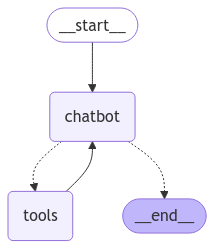

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  


I'm trying to understand the concept of "data privacy" in the context of artificial intelligence (AI) and machine learning (ML). Can you explain it to me?

Absolutely, I'd be happy to help! Data privacy in AI and ML refers to the protection of personal data used in these technologies. Here are some key aspects:

1. **Data Collection**: AI and ML systems often require large amounts of data to function effectively. This data can include personal information, such as names, addresses, or browsing histories. It's crucial to ensure that this data is collected ethically and with proper consent.

2. **Data Storage**: Once collected, data must be stored securely to prevent unauthorized access. This includes both physical security (like locked servers) and digital security (like encryption).

3. **Data Usage**: AI and ML systems use data to learn and make decisions. However, it's important to ensure that this usage respects individual privacy. For example, a system should not use personal data 